In [1]:
import pandas as pd
file_path = "/kaggle/input/stock-market-prediction-and-sentimental-analysis/Combined_News_DJIA(train).csv"

# 讀取 CSV 文件
text_df = pd.read_csv(file_path)
print(text_df.head())

         Date  Label                                               Top1  \
0  2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...   
1  2008-08-11      1  b'Why wont America and Nato help us? If they w...   
2  2008-08-12      0  b'Remember that adorable 9-year-old who sang a...   
3  2008-08-13      0  b' U.S. refuses Israel weapons to attack Iran:...   
4  2008-08-14      1  b'All the experts admit that we should legalis...   

                                                Top2  \
0            b'BREAKING: Musharraf to be impeached.'   
1        b'Bush puts foot down on Georgian conflict'   
2                 b"Russia 'ends Georgia operation'"   
3  b"When the president ordered to attack Tskhinv...   
4  b'War in South Osetia - 89 pictures made by a ...   

                                                Top3  \
0  b'Russia Today: Columns of troops roll into So...   
1  b"Jewish Georgian minister: Thanks to Israeli ...   
2  b'"If we had no sexual harassment we woul

In [2]:
# 假設 text_df 是你的數據
def clean_text(text):
    try:
        # 將任何類型的數據轉換為字符串
        text = str(text)
        # 清理前後的多餘字符
        return text.strip("b'").strip('"')
    except Exception as e:
        # 如果轉換失敗，返回空字符串
        print(f"Error processing text: {text}, error: {e}")
        return ''

# 清理 Top1~Top25 欄位
for i in range(1, 26):
    column = f"Top{i}"
    text_df[column] = text_df[column].apply(clean_text)

# 處理缺失值
text_df.fillna('', inplace=True)

# 合併文本
text_df['Combined_Text'] = text_df[[f"Top{i}" for i in range(1, 26)]].apply(lambda x: ' '.join(x), axis=1)

# 檢查結果
print(text_df[['Combined_Text', 'Label']].head())


                                       Combined_Text  Label
0  Georgia 'downs two Russian warplanes' as count...      0
1  Why wont America and Nato help us? If they won...      1
2  Remember that adorable 9-year-old who sang at ...      0
3   U.S. refuses Israel weapons to attack Iran: r...      0
4  All the experts admit that we should legalise ...      1


# 訓練文本模型產生情緒分數

In [3]:
from sklearn.model_selection import train_test_split

# 分割數據
train_texts, val_texts, train_labels, val_labels = train_test_split(
    text_df['Combined_Text'], text_df['Label'], test_size=0.2, random_state=42)

In [4]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# 加載預訓練的 RoBERTa Tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# 加載 RoBERTa 預訓練模型，設置分類數（假設兩類：漲和跌）
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# 將文本轉換為 RoBERTa 格式
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

In [6]:
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaModel
from torch.optim import AdamW
import torch.nn as nn

In [7]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# 創建數據集
train_dataset = SentimentDataset(train_encodings, train_labels.tolist())
val_dataset = SentimentDataset(val_encodings, val_labels.tolist())

In [8]:
# 檢查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# 載入 RoBERTa 模型和 tokenizer
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.to(device)  # 移動模型到 GPU

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# 創建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=16)

# 優化器
optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
class RoBERTaWithLinear(nn.Module):
    def __init__(self, roberta_model_name='roberta-base', num_labels=1):  # num_labels 改為1
        super(RoBERTaWithLinear, self).__init__()
        
        # 加載預訓練的 RoBERTa 模型
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        
        # 在 RoBERTa 基礎上添加一層線性層，num_labels 改為1
        self.linear = nn.Linear(self.roberta.config.hidden_size, num_labels)  # num_labels 改為1
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # 前向傳播過程
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        # RoBERTa 的最後一層輸出
        hidden_state = roberta_outputs.last_hidden_state
        # 取得 [CLS] token 的表示（通常用來做分類）
        cls_token_state = hidden_state[:, 0, :]  # [batch_size, hidden_size]
        
        # 通過線性層進行處理，輸出單一值
        logits = self.linear(cls_token_state)  # [batch_size, 1]
        
        probs = torch.sigmoid(logits)  # 轉換為概率
        preds = (probs > 0.5).int()  # 將概率轉換為標籤（0 或 1）
        
        return probs, preds

In [11]:
# 定義模型並移動到 GPU
model = RoBERTaWithLinear(num_labels=1)  # 二分類任務，num_labels 改為 1
model.to(device)

# 使用 AdamW 優化器
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# 損失函數：BCEWithLogitsLoss（適用於二分類）
loss_fn = nn.BCEWithLogitsLoss()

# 設置早停參數
patience = 3  # 訓練不改善多少個 epoch 停止
best_val_loss = float('inf')  # 記錄最佳的驗證集損失
patience_counter = 0  # 記錄沒有改善的 epoch 次數


# 儲存預測標籤
train_predicted_labels = []
test_predicted_labels = []

# 訓練過程
model.train()
for epoch in range(3):  # 訓練 3 個 epoch
    for batch in train_dataloader:
        # 將數據移動到 GPU
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # 清空梯度
        optimizer.zero_grad()

        # 前向傳播
        probs, preds = model(**inputs)  # 這裡會呼叫 RoBERTaWithLinear 的 forward 方法
        if epoch == 2:
            train_predicted_labels.extend(preds.cpu().numpy())
        # 計算損失
        loss = loss_fn(probs.squeeze(), labels.float())  # 使用 BCEWithLogitsLoss，labels 需要是浮點型
        
        
        # 反向傳播和梯度更新
        loss.backward()
        optimizer.step()

    # 計算驗證集的損失，這裡假設你有一個 val_dataloader
    model.eval()  # 設置為評估模式
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)
            
            probs, preds = model(**inputs)
            if epoch == 2:
                test_predicted_labels.extend(preds.cpu().numpy())
            loss = loss_fn(probs.squeeze(), labels.float())
            val_loss += loss.item()
    
    # 計算驗證集的平均損失
    val_loss /= len(val_dataloader)
    print(f"Epoch: {epoch}, Train Loss: {loss.item()}, Validation Loss: {val_loss}")
    
    # 如果驗證集的損失比最佳損失要低，更新最佳損失並重置 patience 計數器
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 重置計數器
        # 儲存最佳模型
        torch.save(model.state_dict(), 'best_roberta_with_linear.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break  # 停止訓練
    model.train()  # 訓練模式繼續

# 訓練完後，保存模型
torch.save(model.state_dict(), 'roberta_with_linear_finetuned.pth')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0, Train Loss: 0.691392719745636, Validation Loss: 0.6923480105400085
Epoch: 1, Train Loss: 0.6911535859107971, Validation Loss: 0.6920922636985779
Epoch: 2, Train Loss: 0.688886284828186, Validation Loss: 0.6910176157951355


In [12]:
test_texts = [
    "最近股市波動加劇，投資者對未來的市場走向充滿不確定性。儘管如此，許多分析師仍預測科技股將繼續領漲，特別是在人工智能和雲計算領域。",
    "隨著美國聯準會繼續加息，美元強勢上漲，這對新興市場經濟造成了壓力，尤其是在外債負擔較重的國家。",
    "全球原油價格上漲對許多國家而言都是一大挑戰。雖然一些能源公司獲得了可觀的利潤，但消費者和中小型企業面臨著更高的燃料成本，經濟增長受到了拖累。",
    "在疫情過後，全球供應鏈問題依然未得到完全解決，造成了許多行業的生產延誤，並推高了商品價格。",
    "隨著金融科技的迅速發展，數字貨幣和區塊鏈技術成為投資者熱議的話題。儘管如此，監管機構仍對其未來的發展和市場的穩定性表示擔憂。",
    "大型企業不斷增長的現金流使得股東回報上升，並且許多公司選擇了股票回購計劃來進一步推動股價上漲。"
]


In [13]:
# 創建數據集（類似於訓練過程中的方式）
class TestSentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

In [14]:
# 預處理文本（將文本轉換為模型的輸入格式）
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# 創建測試數據集
test_dataset = TestSentimentDataset(test_encodings)

# 使用 DataLoader 進行批處理
test_dataloader = DataLoader(test_dataset, batch_size=16)

# 儲存預測標籤
predicted_labels = []

# 評估過程
with torch.no_grad():
    for batch in test_dataloader:
        # 將數據移動到 GPU
        inputs = {key: value.to(device) for key, value in batch.items()}

        # 前向傳播
        logits = model(**inputs)  # 預測結果
        # 使用 sigmoid 函數將 logits 轉換為機率
        probs = torch.sigmoid(logits[0]).squeeze()  # 測試時的機率
        print(probs)
        # 轉換機率為二分類標籤：0 或 1
        preds = (probs > 0.5).long()  # 機率大於 0.5 預測為 1，否則為 0



# 輸出預測的情緒分類標籤
print(predicted_labels)

tensor([0.5061, 0.5091, 0.5077, 0.5044, 0.5046, 0.5083], device='cuda:0')
[]


# load DJIA 股價資料

In [149]:


# 定義檔案路徑
file_path = "/kaggle/input/stock-market-prediction-and-sentimental-analysis/DJIA_table(train).csv"

# 讀取 CSV 文件
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
# 按日期升序排序
df = df.sort_values(by='Date', ascending=True).reset_index(drop=True)
# 查看數據結構
print(df.tail())  # 查看前 5 行數據
print(df.info())  # 查看數據類型和非空數量


           Date         Open         High          Low        Close    Volume  \
1858 2015-12-24  17593.25977  17606.33984  17543.94922  17552.16992  40350000   
1859 2015-12-28  17535.66016  17536.90039  17437.33984  17528.26953  59770000   
1860 2015-12-29  17547.36914  17750.01953  17547.36914  17720.98047  69860000   
1861 2015-12-30  17711.93945  17714.13086  17588.86914  17603.86914  59760000   
1862 2015-12-31  17590.66016  17590.66016  17421.16016  17425.02930  93690000   

        Adj Close  
1858  17552.16992  
1859  17528.26953  
1860  17720.98047  
1861  17603.86914  
1862  17425.02930  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863 entries, 0 to 1862
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1863 non-null   datetime64[ns]
 1   Open       1863 non-null   float64       
 2   High       1863 non-null   float64       
 3   Low        1863 non-null   float64       
 4   

/tmp/ipykernel_30/110869027.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [150]:
# 將訓練集和測試集的情緒預測標籤合併
all_predicted_labels = train_predicted_labels + test_predicted_labels

# 檢查預測標籤長度是否等於 df 的長度
#assert len(all_predicted_labels) == 
print(len(train_predicted_labels))
print(len(test_predicted_labels))
print(len(all_predicted_labels))
print(len(df))
# # 將情緒標籤與 df 合併（這裡假設 'df' 的長度等於 'all_predicted_labels'）
# df['Sentiment'] = all_predicted_labels[:len(df)]  # 截取與 df 相同長度的預測標籤

1591
398
1989
1863


In [151]:
# 將情緒標籤與 df 合併（這裡假設 'df' 的長度等於 'all_predicted_labels'）
df['Sentiment'] = all_predicted_labels[:len(df)]  # 截取與 df 相同長度的預測標籤
df['Sentiment'] = df['Sentiment'].apply(lambda x: x[0])  # 提取列表中的數字

# 進行標準化

In [152]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Open', 'High', 'Low','Close']] = scaler.fit_transform(
    df[['Open', 'High', 'Low','Close']]
)

In [153]:
window_size = 5
features = ['Open', 'High', 'Low', 'Sentiment']
targets = 'Close'

# 創建窗口數據
data = []
labels = []

for i in range(len(df) - window_size - 1):  # 確保不會超出範圍
    window_data = df[features].iloc[i:i+window_size].values  # 窗口資料
    target = df[targets].iloc[i + window_size]  # 窗口結束後一天的目標值
    data.append(window_data)
    labels.append(target)

data = np.array(data)  # shape: (n_samples, window_size, n_features)
labels = np.array(labels)  # shape: (n_samples,)

print(f"data shape: {data.shape}, labels shape: {labels.shape}")


data shape: (1857, 5, 4), labels shape: (1857,)


In [154]:
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

# 定義數據集類
class StockDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 創建完整數據集
dataset = StockDataset(data, labels)

# 使用 sklearn 的 train_test_split 分割索引
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42,shuffle=False)

# 根據索引創建子數據集
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# 創建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)  # 訓練數據通常需要 shuffle
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # 測試數據不需要 shuffle

# 驗證數據分割
print(f"訓練集大小: {len(train_loader.dataset)}")
print(f"測試集大小: {len(test_loader.dataset)}")


訓練集大小: 1485
測試集大小: 372


In [127]:
# 定義 Transformer 模型
class StockTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, hidden_dim, num_layers, output_dim):
        super(StockTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)  # 將輸入投影到 hidden_dim 維度
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim * 2
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(hidden_dim, output_dim)  # 將 Transformer 輸出投影為標籤維度

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        x = self.output_proj(x.mean(dim=1))  # 聚合時間維度
        return x


In [128]:
# 定義模型參數
input_dim = data.shape[2]  # 輸入特徵維度
hidden_dim = 64           # 隱藏層維度
num_heads = 4             # 多頭注意力頭數
num_layers = 2            # Transformer 層數
output_dim = 1            # 預測目標維度（收盤價）

# 初始化模型、損失函數和優化器
model = StockTransformer(input_dim, num_heads, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()  # 使用均方誤差作為損失函數
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [130]:
# 訓練模型
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

# 測試模型
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for inputs, target in test_loader:
        inputs, target = inputs.to(device), target.to(device).unsqueeze(1)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        targets.extend(target.cpu().numpy())

# 打印測試結果
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(targets, predictions)
print(f"Test MSE: {mse:.4f}")

Epoch [1/10], Loss: 0.1037
Epoch [2/10], Loss: 0.0916
Epoch [3/10], Loss: 0.0648
Epoch [4/10], Loss: 0.0676
Epoch [5/10], Loss: 0.0768
Epoch [6/10], Loss: 0.0725
Epoch [7/10], Loss: 0.0578
Epoch [8/10], Loss: 0.0377
Epoch [9/10], Loss: 0.0208
Epoch [10/10], Loss: 0.0126
Test MSE: 0.0071


In [155]:
# 假設原始資料的 Date 欄位是字串形式，轉換為 datetime 格式
df['Date'] = pd.to_datetime(df['Date'])
df[['Open', 'High', 'Low','Close']] =scaler.inverse_transform(df[['Open', 'High', 'Low','Close']])
df.set_index('Date', inplace=True)

In [156]:
# 取出測試集日期
kplot_df =df['Close'] 
kplot_df

Date
2008-08-08    11734.32031
2008-08-11    11782.34961
2008-08-12    11642.46973
2008-08-13    11532.95996
2008-08-14    11615.92969
                 ...     
2015-12-24    17552.16992
2015-12-28    17528.26953
2015-12-29    17720.98047
2015-12-30    17603.86914
2015-12-31    17425.02930
Name: Close, Length: 1863, dtype: float64

In [157]:
yhat = predictions  # 預測結果
yhats = np.array(yhat).flatten()  # 將列表轉換為NumPy數組，然後扁平化為一維數組

In [165]:
# 假設你的預測結果 yhat 是一維數組，並且已經標準化
yhat_scaled = np.array(yhat)

# 從 scaler 中獲取均值和標準差
mean = scaler.mean_  # 獲取標準化時的均值
std = scaler.scale_   # 獲取標準化時的標準差

# 假設 yhat 是只有一個特徵 (例如 Close 價格)，需要反標準化
yhat = yhat_scaled * std[0] + mean[0]

# 打印反標準化後的結果
print(yhat)

[[17054.209]
 [17047.283]
 [17043.752]
 [17049.438]
 [17059.758]
 [17071.246]
 [17079.006]
 [17083.96 ]
 [17084.902]
 [17086.059]
 [17085.717]
 [17086.947]
 [17078.771]
 [17072.531]
 [17059.008]
 [17037.42 ]
 [16788.314]
 [16753.807]
 [16716.04 ]
 [16677.262]
 [16648.115]
 [16638.643]
 [16644.295]
 [16648.89 ]
 [16663.393]
 [16683.781]
 [16706.584]
 [16717.723]
 [16742.049]
 [16767.998]
 [16793.605]
 [16818.926]
 [17077.066]
 [17093.928]
 [17106.686]
 [17112.498]
 [17115.906]
 [17118.246]
 [17117.447]
 [17116.182]
 [17114.781]
 [17117.654]
 [17117.785]
 [17112.996]
 [17108.963]
 [17104.844]
 [17096.152]
 [17094.697]
 [17104.86 ]
 [17116.121]
 [17135.139]
 [17152.533]
 [17158.191]
 [17155.037]
 [17151.043]
 [17131.564]
 [17118.94 ]
 [17114.695]
 [17105.559]
 [17080.006]
 [17070.219]
 [17066.877]
 [17055.578]
 [17042.305]
 [16768.035]
 [16751.156]
 [16709.889]
 [16663.74 ]
 [16612.123]
 [16544.383]
 [16505.773]
 [16493.19 ]
 [16503.812]
 [16539.027]
 [16579.982]
 [16622.979]
 [16660.008]

In [168]:
kplot_df

Date
2008-08-08    11734.32031
2008-08-11    11782.34961
2008-08-12    11642.46973
2008-08-13    11532.95996
2008-08-14    11615.92969
                 ...     
2015-12-24    17552.16992
2015-12-28    17528.26953
2015-12-29    17720.98047
2015-12-30    17603.86914
2015-12-31    17425.02930
Name: Close, Length: 1863, dtype: float64

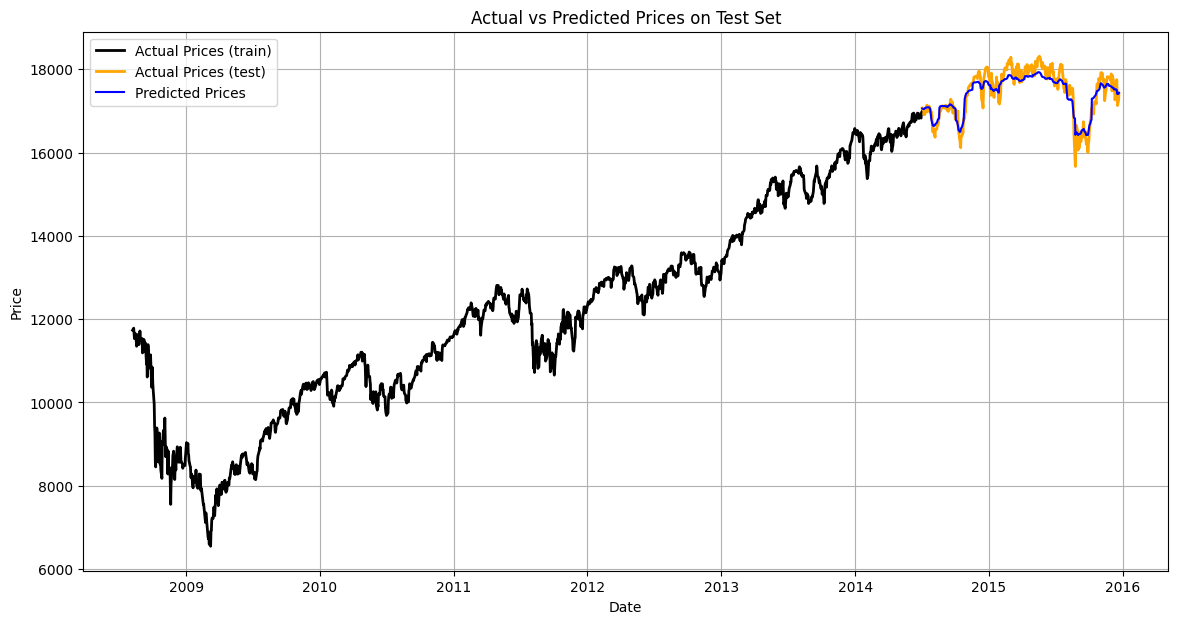

In [178]:
import matplotlib.pyplot as plt
# Assuming `train_dataset` and `yhats` are already defined


# Slice the actual prices for the test set excluding the last 6 values
actual_prices_test = kplot_df[len(train_dataset):len(train_dataset) + len(yhats)]

# Adjust the length of the test dates
test_dates_adjusted = kplot_df.index[len(train_dataset):len(train_dataset) + len(yhats)]

# Plot the data
plt.figure(figsize=(14, 7))

# Training set actual prices
plt.plot(kplot_df.index[:len(train_dataset)], kplot_df[:len(train_dataset)], label='Actual Prices (train)', color='black', linewidth=2)

# Testing set actual prices, adjusted to exclude last 6
plt.plot(test_dates_adjusted, actual_prices_test, label='Actual Prices (test)', color='orange', linewidth=2)

# Predicted prices
plt.plot(test_dates_adjusted, yhat, label='Predicted Prices', color='blue')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()



# 總結:



先使用 Combined_News_DJIA 把Top1~25的文字合併
送入roberta模型進行二分類的文本情緒標籤預測
把情緒標籤當成feature放入 DJIA_table

將DJIA_table.df 取5天為一個window 拿前4天開高低收+情緒標前預測後1天close價格

做法屬於:中期融合(?